In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import matplotlib.dates as mdates
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from datetime import datetime
import numpy as np
import copy

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.losses.pytorch import DistributionLoss

from auserverdata.preparation.rrd import (
    parse_rrds_for_all_collectd_servers,
    parse_rrds_for_all_snmp_servers,
    get_time_series_data_for_collectd_servers,
    get_time_series_data_for_snmp_servers,
    get_feature_names_for_timestamp_set,
    get_feature_names_with_substring_present,
    map_feature_names_to_timestamps,
    map_timestamp_sets_to_feature_names,
    print_timestamp_set_to_feature_names_map_info
)

from auserverdata.local import get_local_config
local_config = get_local_config()

# Data Prep

In [2]:
collectd_ts_df = get_time_series_data_for_collectd_servers(rrd_dir=local_config.rrd_dir, collectd_servers=['gpu18'])
timestamps_per_feature = map_feature_names_to_timestamps(collectd_ts_df)
features_per_timestamp_set = map_timestamp_sets_to_feature_names(timestamps_per_feature)
feature_names = get_feature_names_for_timestamp_set(
                    features_per_timestamp_set,
                    timestamp_set = 0
                    )

feature_label = 'Server Temperature'
ts_names = [feature_label]
start_time = '2020-01-01'
# collectd_ts_df = collectd_ts_df[('gpu18', 'memory', 'memory-used', 'value')]
collectd_ts_df = collectd_ts_df[('gpu18', 'sensors-coretemp-isa-0001', 'temperature-temp10', 'value')]
collectd_ts_df = collectd_ts_df.dropna()
# Convert index to datetime.datetime
collectd_ts_df.index = pd.to_datetime(collectd_ts_df.index)
data_df_1 = pd.DataFrame([collectd_ts_df.index,collectd_ts_df.values]).T
data_df_1.columns = ['ds','y']
data_df_1['unique_id'] = [0 for _ in list(range(len(data_df_1)))]
data_df_1['ds'] = pd.date_range(start=start_time, periods=len(data_df_1), freq='D')
synthetic_to_real_date_map = dict(zip(data_df_1['ds'].values, collectd_ts_df.index.values))
data_df_1['y'] = data_df_1['y'].astype(float)

data_df = data_df_1
ts_df_list = [data_df_1]

In [3]:
data_df_1

,ds,y,unique_id
0,2020-01-01,34.0,0
1,2020-01-02,33.0,0
2,2020-01-03,34.0,0
3,2020-01-04,33.0,0
4,2020-01-05,34.0,0
...,...,...,...
1195,2023-04-10,32.0,0
1196,2023-04-11,34.0,0
1197,2023-04-12,34.0,0
1198,2023-04-13,33.0,0


# Fit and Predict

In [4]:
forecasts_per_horizon_per_ts = []
horizon_list = [10,20,40]
for ts_df in ts_df_list:
    forecasts_per_horizon = {}
    for horizon in horizon_list:
        lags = 2 * horizon
        val_size = 400
        models = [NHITS(h=horizon,                      # Forecast horizon
                        input_size=lags,         # Length of input sequence
                        max_steps=100,                 # Number of steps to train
                        n_freq_downsample=[2, 1, 1],    # Downsampling factors for each stack output
                        mlp_units = 3 * [[1024, 1024]]) # Number of units in each block.
                ]
        nf = NeuralForecast(models=models, freq='D')
        nf.fit(df=ts_df, val_size=val_size)
        step_size = horizon # By setting step_size = horizon, we will get a single prediction for each timestamp
        assert (len(data_df) - horizon) % step_size == 0, 'A different combination of horizon and step_size must be used.'
        Y_hat_insample = nf.predict_insample(step_size=step_size).iloc[horizon:,:]
        Y_hat_insample.index = Y_hat_insample['ds']
        Y_hat_insample['ds'] = Y_hat_insample['ds'].map(synthetic_to_real_date_map)
        Y_hat_insample['cutoff'] = Y_hat_insample['cutoff'].map(synthetic_to_real_date_map)
        Y_hat_insample.index = Y_hat_insample['ds']

        forecasts_per_horizon[horizon] = Y_hat_insample
    forecasts_per_horizon_per_ts.append(forecasts_per_horizon)

Seed set to 1


2024-04-18 00:01:49.212470: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 00:01:49.231589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 00:01:49.231609: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 00:01:49.231627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 00:01:49.235534: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 00:01:49.235842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

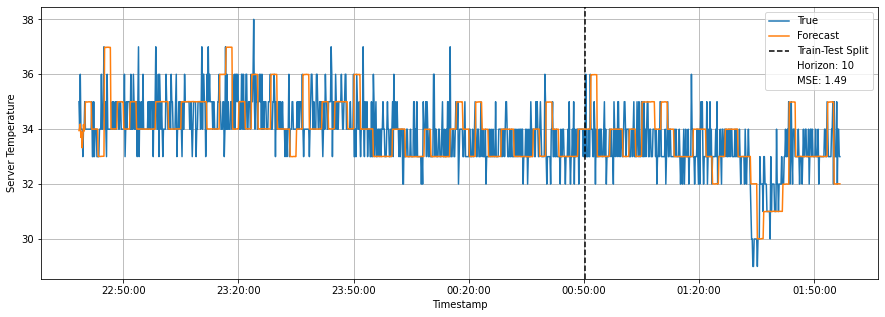

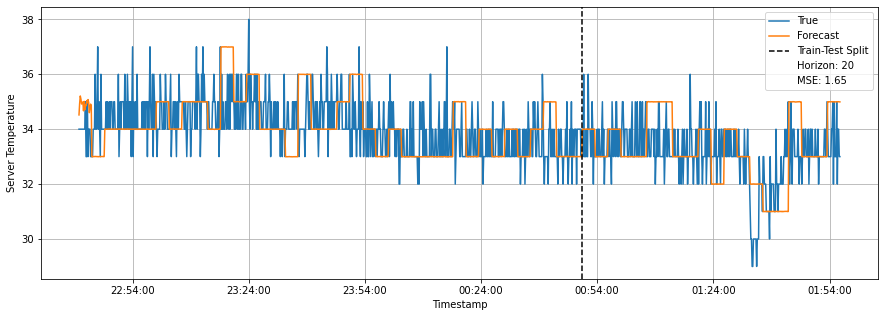

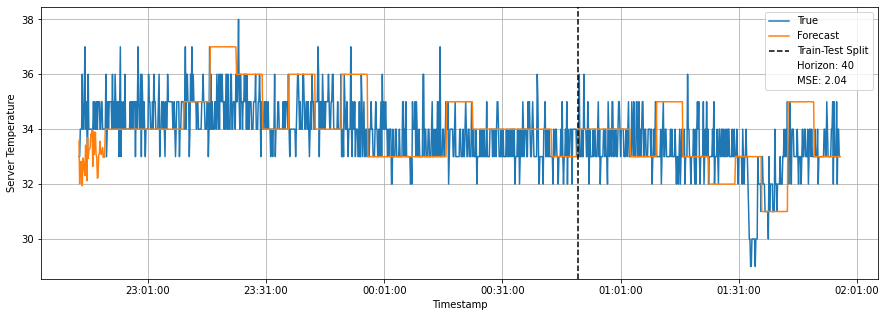

In [5]:
for ts_idx in range(len(ts_df_list)):
    for horizon in horizon_list:
        forecast = copy.copy(forecasts_per_horizon_per_ts[ts_idx][horizon])

        plt.figure(figsize=(15, 5))
        plt.plot(forecast['ds'].values, forecast['y'], label='True')
        plt.plot(forecast['ds'].values, forecast['NHITS'], label='Forecast')
        plt.axvline(forecast['ds'].iloc[-val_size], color='black', linestyle='--', label='Train-Test Split')

        plt.plot([], [], ' ', label=f'Horizon: {horizon}')
        plt.plot([], [], ' ', label=f'MSE: {mean_squared_error(forecast["y"].iloc[-val_size:], forecast["NHITS"].iloc[-val_size:]):.2f}')

        date_fmt = mdates.DateFormatter('%H:%M:%S')
        plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
        plt.gca().xaxis.set_major_formatter(date_fmt)
        plt.xlabel('Timestamp')
        plt.ylabel(f'{feature_label}')
        plt.grid()
        plt.legend()
        plt.show()

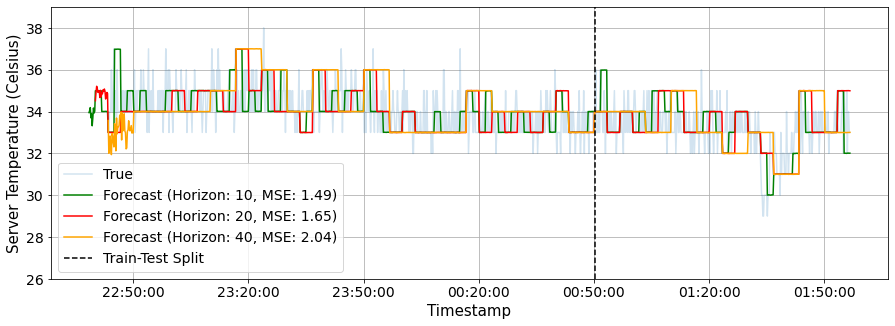

In [6]:
base_color = 'blue'
colors_per_horizon = {10: 'green', 20: 'red', 40: 'orange'}
plt.figure(figsize=(15, 5))
plt.plot(forecast['ds'], forecast['y'], alpha=0.2,label='True')
for ts_idx in range(len(ts_df_list)):
    for horizon in horizon_list:
        forecast = copy.copy(forecasts_per_horizon_per_ts[ts_idx][horizon])
        mse = mean_squared_error(forecast["y"].iloc[-val_size:], forecast["NHITS"].iloc[-val_size:])
        plt.plot(forecast['ds'], forecast['NHITS'], label=f'Forecast (Horizon: {horizon}, MSE: {mse:.2f})', color = colors_per_horizon[horizon])

plt.axvline(forecast['ds'].iloc[-val_size], color='black', linestyle='--', label='Train-Test Split')

date_fmt = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.ylim(26,39)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Timestamp', fontsize=15)
plt.ylabel(f'{feature_label} (Celsius)', fontsize=15)
plt.grid()
plt.legend(fontsize=14, loc='best')
save_path = local_config.figures_dir + f'/server_temp_forecasts_for_different_horizons.png'
plt.savefig(save_path, bbox_inches='tight')

# Generalized AMOC

## Calculate smoothed error

In [7]:
# NOTE: Adapted from telemanom paper's codebase
batch_size = 100 # number of values to evaluate in each batch
window_size = 10 # number of trailing batches to use in error calculation
smoothing_perc = 0.05 # determines window size used in EWMA smoothing (percentage of total values for channel)
error_buffer = 100 # number of values surrounding an error that are brought into the sequence (promotes grouping on nearby sequences
p: 0.13 # minimum percent decrease between max errors in anomalous sequences (used for pruning)
smoothing_window = int(batch_size * window_size * smoothing_perc)

smoothed_error_per_horizon_per_ts = []
for ts_idx in range(len(ts_df_list)):
    smoothed_error_per_horizon = {}
    for horizon in horizon_list:

        forecast = forecasts_per_horizon_per_ts[ts_idx][horizon]

        raw_error = abs(forecast['NHITS'] - forecast['y'])
        raw_error_indices = raw_error.index

        # smoothed prediction error
        smoothed_error = raw_error.ewm(span=smoothing_window).mean().values.flatten()

        # for values at beginning < sequence length, just use avg
        smoothed_error[:lags] = [np.mean(smoothed_error[:lags * 2])] * lags
        smoothed_error = pd.DataFrame(smoothed_error, index = raw_error_indices, columns=['e'])

        smoothed_error_per_horizon[horizon] = smoothed_error
    smoothed_error_per_horizon_per_ts.append(smoothed_error_per_horizon)

## Detect alarms

In [8]:
alarms_per_horizon = {}
for horizon in horizon_list:
    alarms_per_ts = []
    for ts_idx in range(len(ts_df_list)):
        smoothed_errors = smoothed_error_per_horizon_per_ts[ts_idx][horizon]
        # Calculate mean and standard deviation
        alarms_mean = np.mean(smoothed_errors)
        alarms_std = np.std(smoothed_errors)[0]
        alarms_threshold = alarms_mean + (1 * alarms_std)
        # Find indices where values are 2 standard deviations greater than the mean
        alarms = smoothed_errors[smoothed_errors['e'] >= alarms_threshold]
        alarms.columns = ['value']
        alarms_per_ts.append(alarms)
    if len(ts_df_list) > 1:
        alarms = pd.concat(alarms_per_ts,axis=1)
        alarms.columns = ts_names
        # Average the alarm scores across time series
        alarms = alarms.mean(axis=1, skipna=False).to_frame().dropna()
        alarms.columns = ['value']
    alarms_per_horizon[horizon] = alarms

## Prepare positive activity dataframe

## Make synthetic positive activity range

In [9]:
positive_activity_intervals = [
    pd.date_range(start='2023-07-20 01:30:00', end='2023-07-20 01:50:00', freq='1T'),
    # pd.date_range(start='06-01-2011', end='01-01-2014', freq='1D')
]
positive_activity_range = np.concatenate([x.values for x in positive_activity_intervals])
positive_activity = [1 if x in positive_activity_range else 0 for x in collectd_ts_df.index] # NOTE: MAKE SURE THE INDEX/DATE RANGE IS CORRECT
positive_activity = pd.DataFrame(positive_activity, index = collectd_ts_df.index).iloc[horizon:,:] # NOTE: MAKE SURE THE INDEX/DATE RANGE IS CORRECT
positive_activity.columns = ['value']

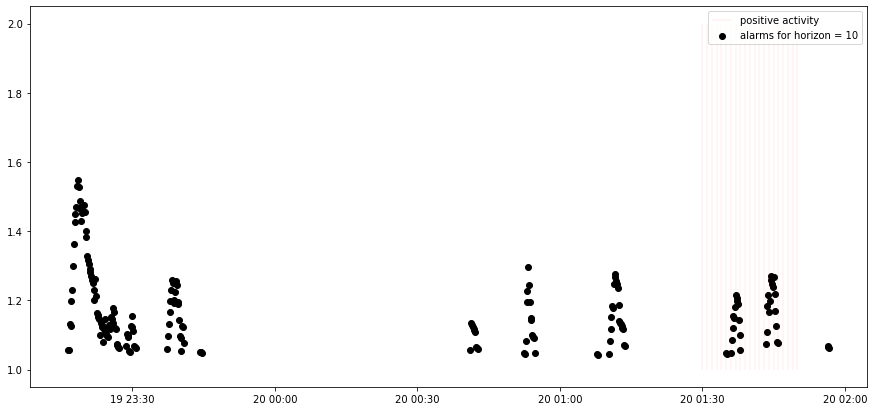

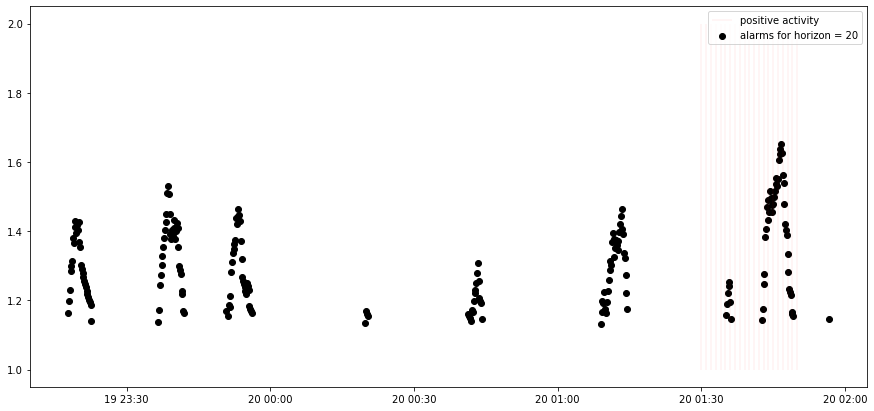

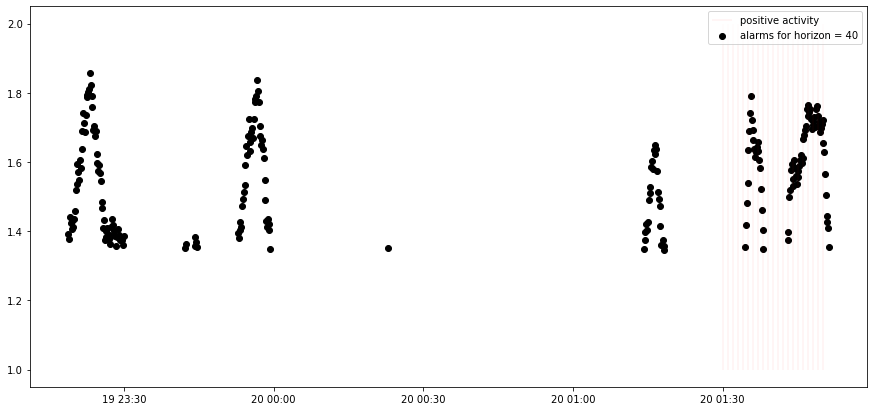

In [10]:
for horizon, alarms in alarms_per_horizon.items():
    plt.figure(figsize=(15,7))
    plt.vlines(positive_activity_range, ymin=1, ymax=2, alpha=0.05, color = 'red', label = 'positive activity')
    plt.scatter(alarms.index, alarms.values, color = 'black', label = f'alarms for horizon = {horizon}')
    plt.legend()

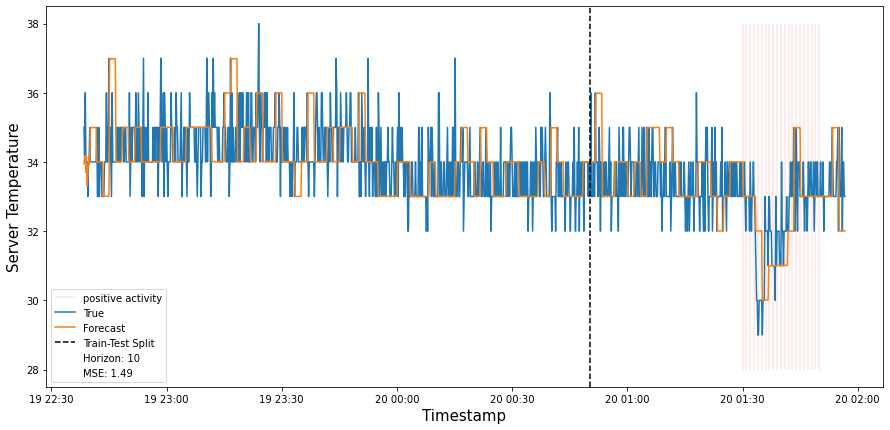

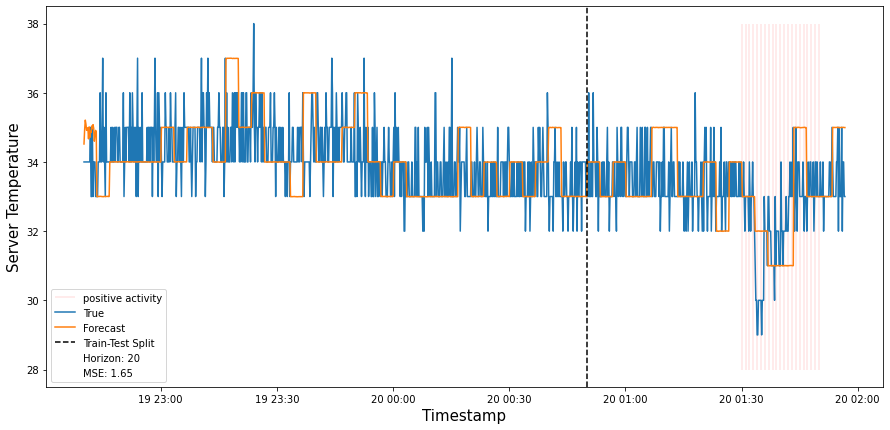

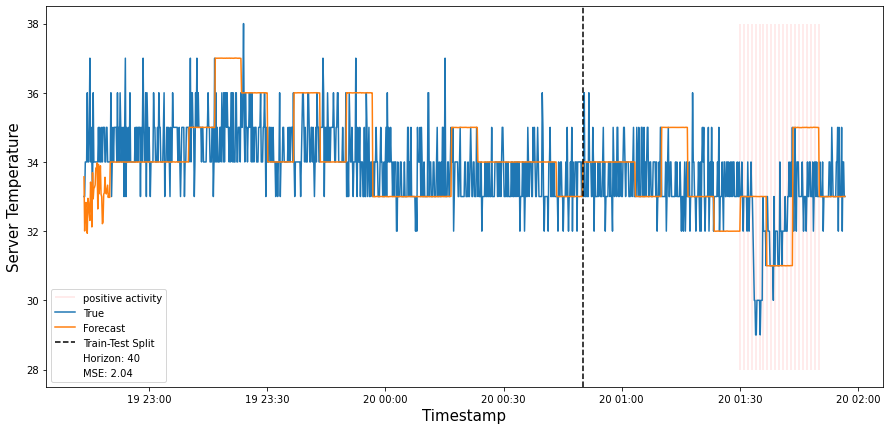

In [11]:
for ts_idx in range(len(ts_df_list)):
    for horizon in horizon_list:
        forecast = forecasts_per_horizon_per_ts[ts_idx][horizon]
        plt.figure(figsize=(15,7))
        plt.vlines(positive_activity_range, ymin=28, ymax=38, alpha=0.1, color = 'red', label = 'positive activity')
        plt.plot(forecast.index, forecast['y'], label='True')
        plt.plot(forecast.index, forecast['NHITS'], label='Forecast')
        plt.axvline(forecast['ds'].iloc[-val_size], color='black', linestyle='--', label='Train-Test Split')

        plt.plot([], [], ' ', label=f'Horizon: {horizon}')
        plt.plot([], [], ' ', label=f'MSE: {mean_squared_error(forecast["y"].iloc[-val_size:], forecast["NHITS"].iloc[-val_size:]):.2f}')
        # plt.plot(smoothed_error, alpha = 0.5, label = 'smoothed error')
        # plt.scatter(alarms.index, alarms.values, color = 'black', label = 'alarms')
        plt.legend(loc='lower left')
        plt.xlabel('Timestamp', fontsize=15)
        plt.ylabel(f'{feature_label}', fontsize=15)


## Create G-AMOC Curve

In [12]:
def has_k_alarms(horizon_df, Z):
    n_alarms_within_curr_horizon = 0
    for timestamp in horizon_df.index:
        if horizon_df['alarm'].loc[timestamp] > 0:
            n_alarms_within_curr_horizon += 1
            if n_alarms_within_curr_horizon >= Z:
                return True
    return False

def has_k_consecutive_alarms(horizon_df, Z):
    consecutive_alarm_count = 0
    for timestamp in horizon_df.index:
        if horizon_df['alarm'].loc[timestamp] != 0:
            consecutive_alarm_count += 1
            if consecutive_alarm_count == Z:
                return True
        else:
            consecutive_alarm_count = 0
    return False

def meets_normal_amoc_criteria(horizon_df, Z):
    # Check if the current day's score exceeds Z
    if horizon_df['alarm'].iloc[-1] >= Z:
        return True
    return False

def trigger_investigation(
    investigation_criteria:str,
    horizon_df:pd.DataFrame,
    Z:any
    ):
    if investigation_criteria=='normal_amoc': return meets_normal_amoc_criteria(horizon_df=horizon_df, Z=Z)
    elif investigation_criteria=='k_alarms': return has_k_alarms(horizon_df=horizon_df, Z=Z)
    elif investigation_criteria=='k_consecutive_alarms': return has_k_consecutive_alarms(horizon_df=horizon_df, Z=Z)
    else: raise ValueError(f'The given investigation_criteria ({investigation_criteria}) is not available.')


In [13]:
investigation_criteria = 'k_alarms'
amoc_per_horizon = {}
for horizon in horizon_list:
    Z_thresholds = list(range(horizon))[1:] # Z in the G-AMOC paper
    amoc_points = []
    horizons_for_postive_investigation = []
    mean_time_to_detection = None
    # Build a df with the alarms and the positive activity identified
    alarms = alarms_per_horizon[horizon]
    analysis_df = pd.merge(left=positive_activity, right=alarms, left_index=True, right_index=True, how='outer')
    analysis_df.columns = ['positive_activity','alarm']
    analysis_df['alarm'] = analysis_df['alarm'].fillna(0)
    analysis_df['positive_activity'] = analysis_df['positive_activity'].fillna(0)

    n_non_positive_timestamps = analysis_df[analysis_df['positive_activity'] == 0].shape[0]

    # Iterate through each Z threshold
    for Z_threshold in Z_thresholds:
        n_misses = 0 # Number of positive activity intervals missed
        n_false_investigations = 0 # Number of false investigations triggered
        time_to_detection_list = [] # List containing the time to detect positive activity, length equal to n_positive_intervals - n_misses
        positive_activity_interval_idx = 0 # Index of the positive activity interval
        positive_activity_interval = positive_activity_intervals[positive_activity_interval_idx] # List of timestamps in the positive activity interval

        n_horizons_checked = 0
        # Iterate over each timestamp which was forecast (excludes the first horizon timestamps)
        for timestamp_idx in range(horizon, len(analysis_df)):
            n_horizons_checked += 1
            # Retireve the current timestamp
            curr_timestamp = analysis_df.index[timestamp_idx]

            # Check if we've gone past the current positive activity interval without triggering a positive investigation
            if curr_timestamp > positive_activity_interval[-1]:
                print('A positive interval was missed!')
                n_misses += 1
                positive_activity_interval_idx += 1
                time_to_detection_list.append(None)
                # Check whether all positive intervals have passed
                if positive_activity_interval_idx == len(positive_activity_intervals):
                    filtered_time_to_detection_list = [x for x in time_to_detection_list if x != None]
                    if len(filtered_time_to_detection_list) == 0:
                        mean_time_to_detection = None
                    else:
                        mean_time_to_detection = np.mean(filtered_time_to_detection_list).total_seconds()
                    break
                # Switch to the next positive interval because there is only one positive investigation per positive activity interval
                else:
                    print('Switching to next positive interval!')
                    positive_activity_interval = positive_activity_intervals[positive_activity_interval_idx]

            # Get the timestamps within the current horizon (ie the past *horizon* timestamps)
            timestamps_within_horizon = analysis_df.index[timestamp_idx-horizon:timestamp_idx]
            horizon_df = analysis_df.loc[timestamps_within_horizon, :]

            # Check if the horizon's alarms satisfy the threshold (ie start investigation)
            if trigger_investigation(investigation_criteria=investigation_criteria, horizon_df=horizon_df, Z=Z_threshold):
                # Check if the current horizon is within the current positive activity interval
                # True Investigation
                if len(list(set(positive_activity_interval).intersection(set(horizon_df.index)))) > 0:
                    print('A positive interval was hit!')
                    breakpoint()

                    horizons_for_postive_investigation.append(horizon_df) # for testing

                    # Get the last timestamp of the horizon
                    last_timestamp_in_horizon = horizon_df.index[-1]

                    # Get the first timestamp of the current positive activity interval
                    first_timestamp_of_positive_activity_interval = positive_activity_interval[0]

                    # Calculate the time to detection for the current positive activity interval
                    time_to_detection = last_timestamp_in_horizon - first_timestamp_of_positive_activity_interval

                    # Store the time to detection for the current positive activity interval
                    time_to_detection_list.append(time_to_detection)

                    # Increment the positive activity interval
                    positive_activity_interval_idx += 1

                    # Check whether all positive intervals have passed
                    if positive_activity_interval_idx == len(positive_activity_intervals):
                        filtered_time_to_detection_list = [x for x in time_to_detection_list if x != None]
                        if len(filtered_time_to_detection_list) == 0:
                            mean_time_to_detection = None
                        else:
                            mean_time_to_detection = np.mean(filtered_time_to_detection_list).total_seconds()
                        break
                    # Switch to the next positive interval because there is only one positive investigation per positive activity interval
                    else:
                        print('Switching to next positive interval!')
                        positive_activity_interval = positive_activity_intervals[positive_activity_interval_idx]

                # False investigation
                else:
                    n_false_investigations += 1

        amoc_points.append((n_false_investigations, mean_time_to_detection, n_misses, n_horizons_checked))
        print('*'*40)

    amoc_points = np.array(amoc_points)
    amoc = pd.DataFrame(np.append(amoc_points, np.array(Z_thresholds).reshape(-1,1), axis = 1), columns = ['n_false_investigations', 'mean_time_to_detection', 'n_misses', 'n_horizons_checked', 'z_threshold'])
    filtered_n_false_investigations = amoc.dropna()['n_false_investigations'].to_numpy().astype(int)
    filtered_mean_time_to_detection = amoc.dropna()['mean_time_to_detection'].to_numpy().astype(int)
    assert np.all(np.diff(filtered_n_false_investigations) <= 0), 'The number of false investigations is not monotonically decreasing.'
    assert np.all(np.diff(filtered_mean_time_to_detection) >= 0), 'The mean time to detection is not monotonically increasing'
    amoc_per_horizon[horizon] = amoc

A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval was hit!
****************************************
A positive interval 

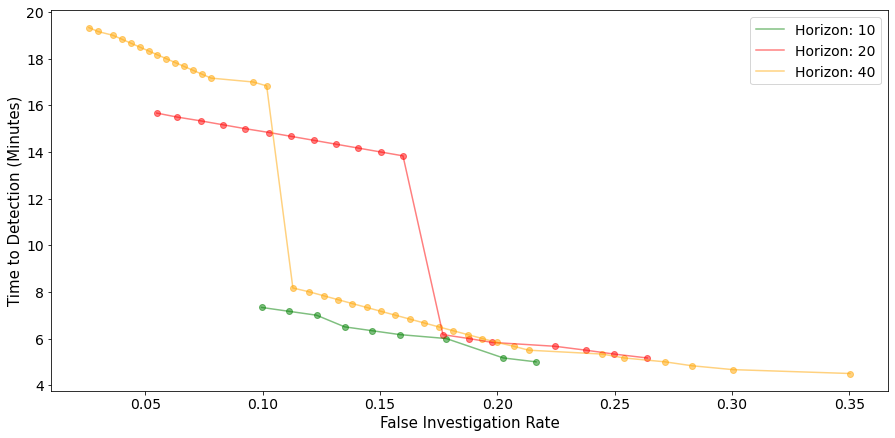

In [16]:
plt.figure(figsize=(15,7))
for horizon in horizon_list:
    amoc = amoc_per_horizon[horizon]
    amoc = amoc.dropna()
    plt.plot(amoc.loc[:,'n_false_investigations'] / amoc.loc[:,'n_horizons_checked'], amoc.loc[:,'mean_time_to_detection'] / 60,
             alpha = 0.5, color = colors_per_horizon[horizon], label = f'Horizon: {horizon}')
    plt.scatter(amoc.loc[:,'n_false_investigations'] / amoc.loc[:,'n_horizons_checked'], amoc.loc[:,'mean_time_to_detection'] / 60 ,
                alpha = 0.5, color = colors_per_horizon[horizon])

# plt.yscale('log')
# Set tick label fontsize
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Investigation Rate', fontsize=15)
plt.ylabel('Time to Detection (Minutes)', fontsize=15)
plt.legend(fontsize=14)
save_path = local_config.figures_dir + f'/g-amoc_for_server_temp_forecasts_for_different_horizons.png'
plt.savefig(save_path, bbox_inches='tight')
